# R: Reserving with LASSO


*In this post we look at how regularised regression techniques such as the LASSO can be used to set reserves for triangles.*

The [Foundation Workstream's first post](/mlr-blog/post/intro-to-foundations-blog/) set out a suggested path to getting to grips with machine learning. The first step was to start by applying GLMs to reserving and one way of doing this was covered in our most recent post ([Reserving with GLMs](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/glms/)).

In this post, we move onto the next step which is to use regularised regression methods. These allow us to build something that looks like a GLM but in a machine learning way - i.e. the machine selects the model.
Put simply, regularisation techniques shrink or regularise regression parameters towards zero (excluding the intercept - this is normally not regularised, so in effect, this means that the fitted values are regularised towards the constant term in the regression). This penalises more complex models and reduces the risk of overfitting.

Here we will be focussing on a particular type of regularised regression, called the LASSO. As well as shrinking the parameters towards zero, the LASSO also selects parameters (and their corresponding regressor) by explicitly setting some to zero. This makes it a particularly useful method.

Below we will first provide a brief technical overview of the LASSO for those interested, before moving onto a practical example.   

# Introduction to the LASSO

The LASSO (**L**east **A**bsolute **S**hrinkage and **S**election **O**perator) is a form of regularised regression. This means that the regression is subject to a penalty for the addition of each additional term in the predictor. The purpose of this is to prevent over-fitting of the model to data.

## From GLMs ...

The loss function associated with a GLM regression is the **deviance**, defined as

$$D(y; X, \hat{\beta}) = -\sum_{i=1}^N \ell (y_i; X, \hat{\beta})  + \text{other terms}$$

where:

* $y$ is the *N*-vector of observations $y_i$

* $X$ is the regression design matrix

* $\beta$ is the *p*-vector of coefficients $\beta_j$ in the linear predictor

* $\hat{\beta}$ is the regression estimate of $\beta$

* $\ell (y_i; X, \hat{\beta})$ is the log-likelihood of observation $y_i$

* the other terms are of no great interest here.

Parameter estimation of a GLM can be performed by minimisation of the deviance with respect to $\hat{\beta}$, which is equivalent to maximisation of the likelihood.

## ... to the LASSO

The loss function for the LASSO version of this GLM is:

$$\mathcal{L} (y; X, \hat{\beta}) = D(y; X, \hat{\beta}) + \lambda ||\hat{\beta}||_1$$

where:

* $\lambda ||\hat{\beta}||_1$ is the parameter penalty or regularisation

* $||\hat{\beta}||_1 = \sum_{j=1}^p | \hat{\beta}_j|$ is the $L_1$ norm of $\hat{\beta}$ (which is the absolute value)

* $\lambda \geq 0$ is a tuning parameter controlling the size of the penalty and therefore the amount of the regularisation.

LASSO parameter estimation is effected by minimisation of $\mathcal{L} (y; X, \hat{\beta})$ with respect to $\hat{\beta}$. The quantity $\lambda ||\hat{\beta}||_1$ adds a penalty for each non-zero coefficient.

## Model selection

The non-differentiability of the penalty function tends to cause the occurrence of corner solutions in the minimisation, so that some coefficients $\hat{\beta}_j$ are forced to zero.  
The strength of this effect increases with $\lambda$. In the limit $\lambda=0$, the LASSO is the same as the GLM; in the limit $\lambda \rightarrow \infty$, the LASSO model becomes null, i.e. $\hat{\beta} = 0$ (other than the intercept if this has not been regularised). Thus, as $\lambda$ increases from 0 to $\infty$, the LASSO model shifts from the relatively complex GLM to increasingly simpler representations of the data.

In practical use, models are fitted for a number of different possible values of $\lambda$ (a path of values, from high to low).
Cross-validation may then be used to select a particular $\lambda$, and therefore model - one popular choice is the model which minimises the selected error measure over the different folds. Another popular alternative is to select the model with an average error across the folds that is one standard deviation away from the minimum. In this case, it is always the simpler model (i.e. higher $\lambda$ value) that is selected with the aim of further reducing the risk of overfitting.

There is a Bayesian version of the LASSO (further details in the paper, and references therein), in which it is viewed as a hierarchical model, consisting of the original GLM with randomised parameters, each subject to the Laplace prior density:

$$ \pi(\beta_j) = \frac{1}{2} \lambda \exp( -\lambda | \beta_j |), \space\space\space\space -\infty < \beta_j < \infty .$$

The LASSO is dealt with in more detail in [Hastie T, Tibshirani R and Friedman J. (2009). **The Elements of Statistical Learning: Data Mining, Inference and Prediction**. Springer, New York USA.](https://web.stanford.edu/~hastie/ElemStatLearn/)

# Using the LASSO for reserving

In GIRO 2018 (and presented again at TIGI 2019), we, along with our co-author Hugh Miller, describe how the LASSO could be used to carry out reserving for a traditional triangle.
The motivation behind this work was to develop an automatic method to construct a general insurance claims reserving model for data sets with complex features where simple approaches such as the chain ladder fail. In the past we have advocated the use of GLM models for such data sets, but the construction of a GLM is a time-consuming process, even for a skilled analyst. Our aim was to develop a procedure that produced a model similar to a GLM, but using machine learning techniques.

We used the LASSO rather than other types of regularised regression, for the following reasons:

* The ability of the LASSO to select parameters (by setting some parameter estimates to zero)
* The LASSO leads to lower error variance in the fitted values (at the cost of some additional bias).

This approach has performed well - as may be seen from the figures towards the end of this article, which show that the fitted curves can track the underlying specification quite closely, even in the presence of significant noise, or difficult to detect interactions. A paper describing the method is available on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906). This contains much more technical detail around the choice, use and implementation of the LASSO for the reserving problem.

For the rest of this post, we will work through this method in a tutorial example.
This is based on an existing [worked example](https://grainnemcguire.github.io/post/self-assembling-claim-reserving-models/) so if you've seen that one, then you may already be familiar with a lot of the content below.

# Tutorial on how to use our LASSO technique for reserving

In our paper we investigate the use of the LASSO using four synthetic (i.e. simulated) data sets as well as a real data set. This worked example will use the third simulated data set. The specifications for this data set are given in Section 4.2.1 of the paper. The main points to note are that this data set:

* is a 40x40 triangle, with
* accident and development period effects
* calendar period effects (i.e. superimposed inflation)
* a step-interaction between accident and development period for accident periods greater than 16 and development periods greater than 20 (note this affects only 10 cells of the triangle)

These effects are represented graphically below.


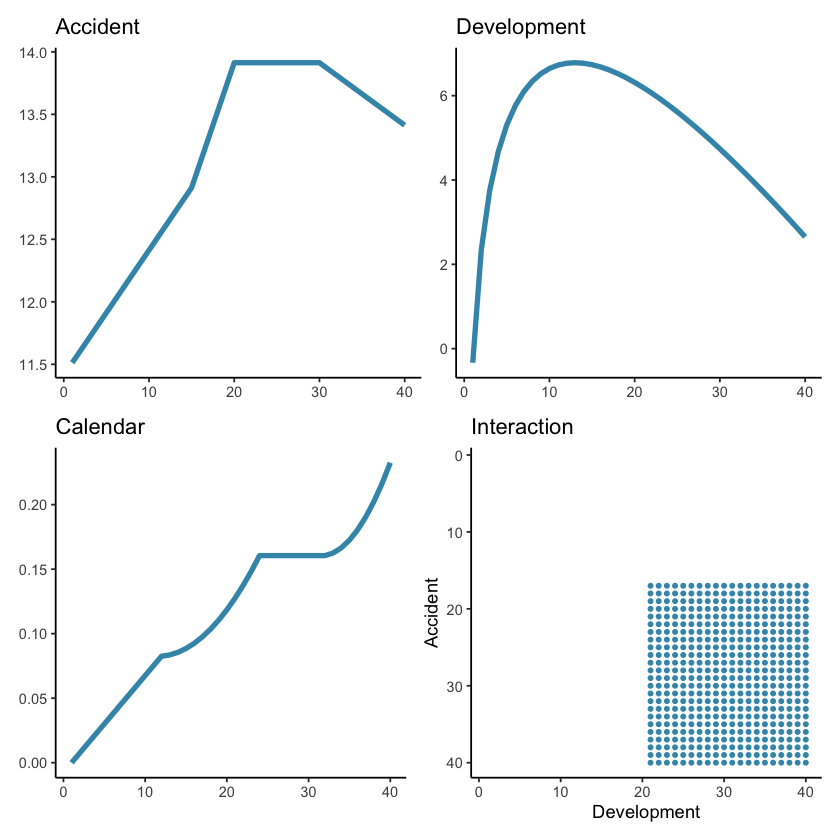

In [1]:
library(data.table)
library(ggplot2)
library(patchwork)
library(IRdisplay) # displays tables when in ipynb format

mblue <- "#4096b8"


# plot effects in data

LinearSpline <- function(var, start, stop){
    pmin(stop - start, pmax(0, var - start))
}

# acc
acc_dt <- data.table(acc=1:40)
acc_dt[, acc_m := log(100000)+0.1*LinearSpline(acc,1,15)+0.2*LinearSpline(acc,15,20) - 0.05*LinearSpline(acc,30,40)]

g_acc <- ggplot(data=acc_dt, aes(x=acc, y=acc_m)) +
  geom_line(size=1.5, colour=mblue) +
  theme_classic() +
  labs(x=NULL, y=NULL, title="Accident")

# dev
dev_dt <- data.table(dev=1:40)
dev_dt[, dev_m := (16/3 - 1)*log(dev)- (1/3)*dev]

g_dev <- ggplot(data=dev_dt, aes(x=dev, y=dev_m)) +
  geom_line(size=1.5, colour=mblue) +
  theme_classic() +
  labs(x=NULL, y=NULL, title="Development")

# cal
gammafunc <- function(t){
	gg <-
		ifelse( t<=12, gg <- 0.0075*LinearSpline(t,1,12),
				ifelse(t<=24,  gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (t-12)*(t-11)/2,
					   ifelse(t<=32, gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2,
					   	   ifelse(t<=40, gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2 + 0.002*(t-32)*(t-31)/2,
					   	   	   0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2 + 0.002*(40-32)*(40-31)/2
					   	   ))))
	1*gg  #can scale up shape here if desired
}


cal_dt <- data.table(cal=1:40)
cal_dt[, cal_m := gammafunc(cal)]

g_cal <- ggplot(data=cal_dt, aes(x=cal, y=cal_m)) +
  geom_line(size=1.5, colour=mblue) +
  theme_classic() +
  labs(x=NULL, y=NULL, title="Calendar")


# interactions
int_dt <- data.table(acc=rep(1:40, each=40), dev=rep(1:40, times=40))
int_dt[, interaction := FALSE
       ][acc>16 & dev>20, interaction := TRUE]

g_int <- ggplot(data=int_dt, aes(x=dev, y=acc, colour=interaction)) +
  geom_point(size=1) +
  scale_colour_manual(values=c("white", mblue)) +
  scale_y_reverse()+
  theme_classic() +
  theme(legend.position = "none") +
  labs(x="Development", y="Accident", title="Interaction")


(g_acc + g_dev) / (g_cal + g_int)



## Initial Setup

First we must open R and load any libraries required. These include:

* **data.table** for manipulating data
* **glmnet** to fit the LASSO model
* **ggplot2** and **patchwork** for graphing

If you would prefer all data manipulation in base R, then refer to the [original version of this tutorial]([worked example](https://grainnemcguire.github.io/post/self-assembling-claim-reserving-models/)).




In [2]:
library(data.table)
library(glmnet)
library(ggplot2)
library(patchwork)

library(kableExtra) # format tables nicely
library(magrittr)  # to use the pipe %>%

# other setup
options("scipen"=99) # turn off scientific notation

# colour palette for some plots
# IFoA colours
# primary colours
dblue <- "#113458"
mblue <- "#4096b8"
gold <- "#d9ab16"
lgrey <- "#dcddd9"
dgrey <- "#3f4548"
black <- "#3F4548"
#secondary colours
red <- "#d01e45"
purple <- "#8f4693"
orange <- "#ee741d"
fuscia <- "#e9458c"
violet <- "#8076cf"



Loading required package: Matrix

Loaded glmnet 4.1-1



## Generating the synthetic data set

The functions defined below will generate data sets similar to those used in our paper.
Here we'll use simulated data set 3, but we've included the code to generate the other data sets so that you can experiment with others if you wish.

The utility function `LinearSpline()` will be widely used in this example - it takes a vector `var` and produces a spline piece between `start` and `stop` - flat (and 0) up to `start`, thereafter increasing to `stop` and then levelling out at this point. This is used both in the data generation and in the generation of basis functions for the LASSO.

In [3]:
LinearSpline <- function(var, start, stop){
	pmin(stop - start, pmax(0, var - start))
}


CreateSyntheticData<-function(whichsim, numperiods)
{

    # whichsim determins which data set to simulate
    # numperiods determines the size of the triangle

	# create the acc/dev/cal parameters
	kk <- rep(1:numperiods, each = numperiods) #AQ
	jj <- rep(1:numperiods, times= numperiods) #DQ
	tt <- kk+jj-1 # PQ

	# set alpha/beta/gamma - hard-code up the sim values
	if (whichsim == 1){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40)
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj
		gamma <- 0
		mu <- exp( alpha + beta + gamma)  
	}
	else if (whichsim == 2){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40)
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj  # a is 16/3, b is 1/3
		gamma <- gammafunc(tt)
		mu <- exp( alpha + beta + gamma)  
	}
	else if (whichsim == 3){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40)
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj  # a is 16/3, b is 1/3
		gamma <- gammafunc(tt)
		mu <- exp( alpha + beta + gamma + 0.3*beta*ifelse(kk>16 & jj>20,1,0))  
	}
	else if (whichsim == 4){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40)
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj  # a is 16/3, b is 1/3
		gamma <- gammafunc(tt)
		mu <- exp( alpha + beta + gamma*((numperiods-1)-LinearSpline(jj,1,numperiods))/(numperiods-1) )  # need to check
	}

	varbase <- (0.3 * mu[  kk==1 & jj ==16] )^2 # can scale variance up and down here
	CC  <-  varbase / mu[  kk==1 & jj ==16]

	vars   <- CC*mu
	tausq  <- log (vars / (mu^2) + 1)

	pmts <- exp( rnorm( numperiods^2, mean = log(mu)-0.5*tausq , sd = sqrt(tausq)  ) )

	# indicator for past/future = traint/test
	train_ind<-(tt<=numperiods)

	### data.table for output
	full<-data.table(pmts, acc=as.integer(kk), dev=as.integer(jj), cal=as.integer(tt), mu, train_ind )
	full
}


#---------------------------
# function to generate calendar period effects used in CreateSyntheticData()
# written as a seperate function for convenience

gammafunc <- function(t){
	gg <-
		ifelse( t<=12, gg <- 0.0075*LinearSpline(t,1,12),
				ifelse(t<=24,  gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (t-12)*(t-11)/2,
					   ifelse(t<=32, gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2,
					   	   ifelse(t<=40, gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2 + 0.002*(t-32)*(t-31)/2,
					   	   	   0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2 + 0.002*(40-32)*(40-31)/2
					   	   ))))
	gg  
}




The code below generates the data set as specified in our paper. If you want to use our data set, use a seed of 130. Otherwise, use different seeds to produce different data sets. Or change `use_data_set` to 1, 2 or 4 to use data sets simulated in a similar way to those in our paper.

In [4]:

use_data_set <- 3       # which data set to use
use_data_set_seed <- 130  # seed to generate data
num_periods <- 40   # size of data set

set.seed(use_data_set_seed)

dat <- CreateSyntheticData(whichsim=use_data_set, numperiods=num_periods)



Let's have a look at the data:

* `acc` / `dev` / `cal` = accident / development / calendar quarter
* `pmts` = simulated payments
* `mu` = underlying mean
* `train_ind`: TRUE for past values and FALSE for future.

In [5]:

# head(dat,10) gives the same information, the rest is just formatting

head(dat, 10) %>%
    kable(digits=0, format.args = list(big.mark = ",", scientific = FALSE)) %>%
    kable_styling(full_width=FALSE, bootstrap_options = c("striped", "hover", "condensed")) %>%
    as.character() %>%
    display_html()




pmts,acc,dev,cal,mu,train_ind
"242,671",1,1,1,"71,653",TRUE
"164,001",1,2,2,"1,042,776",TRUE
"3,224,478",1,3,3,"4,362,600",TRUE
"3,682,531",1,4,4,"10,955,670",TRUE
"10,149,369",1,5,5,"20,800,545",TRUE
"28,578,275",1,6,6,"33,089,167",TRUE
"29,022,301",1,7,7,"46,588,740",TRUE
"56,795,754",1,8,8,"59,989,023",TRUE
"47,360,541",1,9,9,"72,148,133",TRUE
"99,139,255",1,10,10,"82,224,253",TRUE


It may also be helpful to visualise the data, using shading to indicate the size of the payments (specifically, log(payments)).


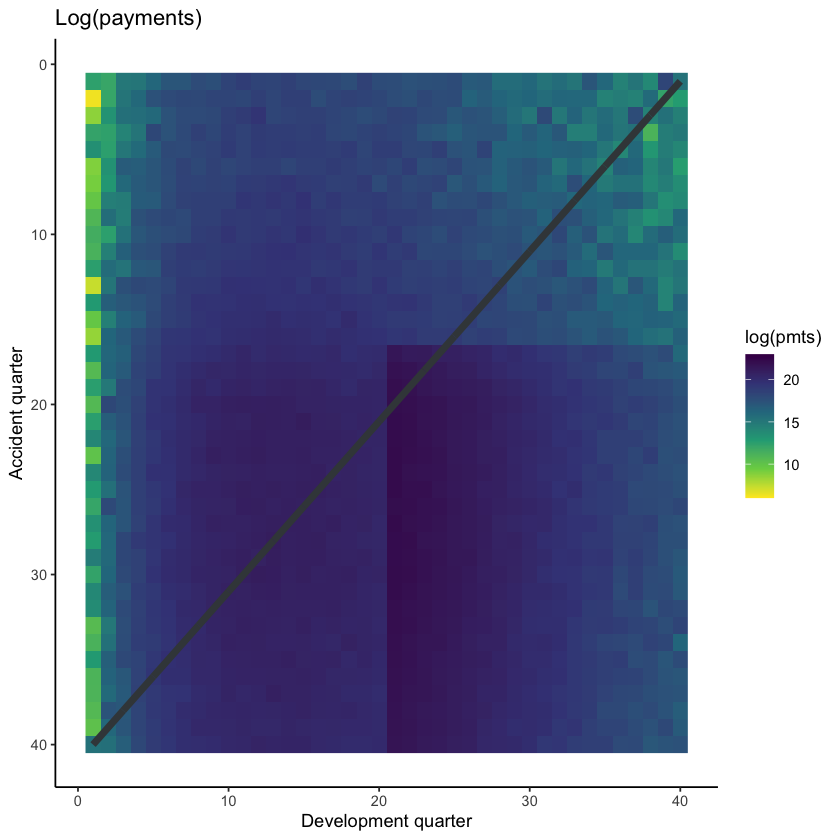

In [6]:

# get limits for use with raster plots
data_raster_limits <- c(floor(dat[, min(log(pmts))]), ceiling(dat[, max(log(pmts))]))

ggplot(dat, aes(dev, acc)) +
  geom_raster(aes(fill = log(pmts)))+
  geom_line(aes(x=num_periods+1-acc, y=acc), colour=dgrey, size=2)+
  scale_y_reverse()+
  scale_fill_viridis_c(begin=1, end=0, limits=data_raster_limits)+
  theme_classic()+
  labs(x="Development quarter", y="Accident quarter", title="Log(payments)")+
  NULL



## Specifying the LASSO model

The LASSO model requires data (which we have), basis functions or regressors and model settings for the LASSO procedure. In our example we have 3 regressors - accident, development and calendar periods. If we use these as is, then all our model can potentially contain are a linear effect related to each of these. That won't come anywhere close to modelling the data.
Therefore, a key part of our paper was how to expand these 3 regressors into a flexible set of basis functions, capable of capturing a variety of shapes in the model experience.

### Set of basis functions

In the paper we proposed creating a basis function set consisting of ramp functions and step (or heaviside) functions, as shown in the plot below:

* Ramps start flat at 0, then have a knot (turning point) after which they increase linearly
* Step or heaviside functions start at 0, then step up to 1 and a specific point and remain there.


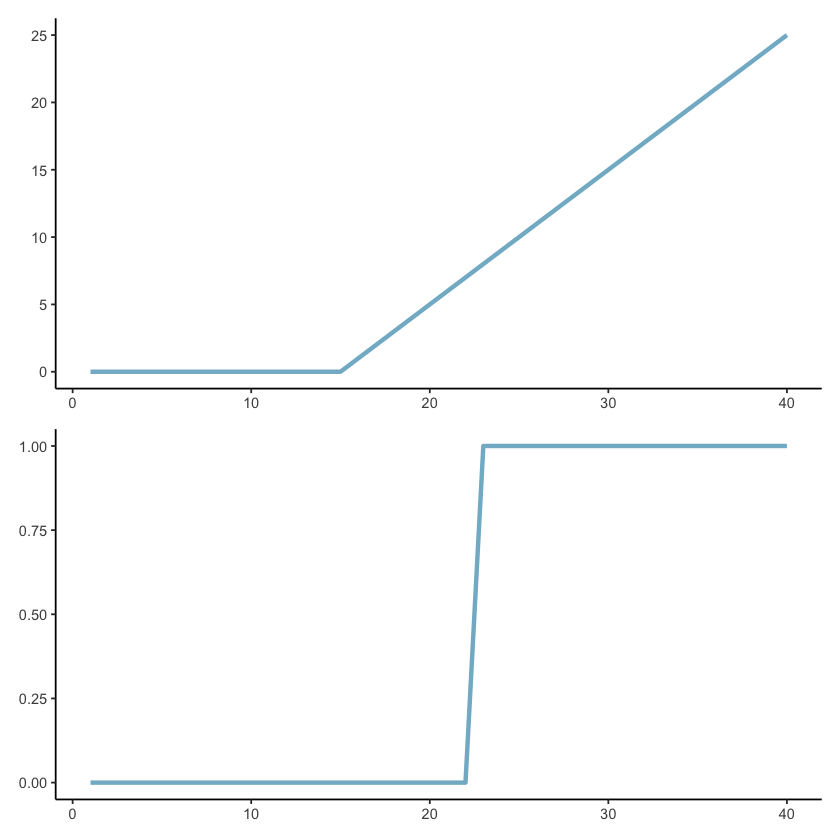

In [7]:

dt1 <- data.table(acc=1:40)
dt1[, ramp1 := pmax(0, acc-15)
    ][, step1 := fifelse(acc<=22, 0, 1)]

dt1_long <- melt(dt1, id.vars="acc")

g1 <- ggplot(data=dt1_long[variable %like% "ramp"], aes(x=acc, y=value, colour=variable))+
  geom_line(size=1.25, alpha=0.7) +
  scale_colour_manual(values=c(mblue)) +
  theme_classic() +
  labs(x=NULL, y=NULL) +
  theme(legend.position = "none")


g2 <- ggplot(data=dt1_long[variable %like% "step"], aes(x=acc, y=value, colour=variable))+
  geom_line(size=1.25, alpha=0.7) +
  scale_colour_manual(values=c(mblue)) +
  theme_classic() +
  labs(x=NULL, y=NULL) +
  theme(legend.position = "none")

g1 / g2


More specifically we use the ramp functions for main effects and the heaviside functions for interactions.

Since the procedure is intended to be automatic, the default basis function set includes all possible main effects ramps and all possible two-way interaction step functions.

For the particular data set here, this means that our basis functions include:

* 3 x 39 ramp functions, e.g.
  $$\max(\text{acc} - k, 0), \;\; k=1, 2, ..., 39$$

  + and similar for `dev` and `cal`.

* 3 x 39 x 39 interactions
  $$I(\text{acc} \geq k)*I(\text{acc} \geq j), \;\; k, j = 2,3,..., 40$$

   + similar for (`acc`, `cal`) and (`dev`, `cal`)

* This leads to 4680(!) basis functions.

Since there are really only 2 regressors (as in, once you know two of accident, development and calendar, you know the third), there are a lot of correlated variables. For real problems (as in the real data example in the paper), where you have prior knowledge about what effects are likely to be in the data we would recommend more discernment in the selection of which of the effects to include. For example, if you expect only development and calendar effects, then do not include the accident period basis functions.

### Scaling

Referring back to the introduction of this article, the loss function to be minimised for the LASSO is

$$\mathcal{L} (y; X, \hat{\beta}) = D(y; X, \hat{\beta}) + \lambda ||\hat{\beta}||_1$$

We noted that $\lambda$ controlled the size of the penalty attaching to each parameter, and therefore each basis function.
However, as the size of the parameters also features in this equation, it is important that the basis functions be on similar scales.
Otherwise whether a parameter is included or not could depend on whether the corresponding basis function has large values (and therefore smaller $\hat{\beta}$) or small values (and therefore larger $\hat{\beta}$), which is clearly undesirable.

Once you're aware of this issue, it should come as no surprise that scaling parameters is something that is common in machine learning work like this one. Indeed, the **glmnet** package which we will be using comes with an in-built scaling tool. However this scaling will scale each variable independently. This isn't what we want since the basis functions are not independent - we have over 4000 of these, but really we only have 3 fundamental regressors so we probably want all `acc` functions to be scaled similarly (and the same is true for `dev` and `cal`).

Our paper has some more discussion around scaling. In a nutshell, we calculate a scaling factor for each of the 3 fundamental regressors and then apply that to all basis functions generated from that regressor. The scaling we use is $\rho$ scaling which is calculated as

$$\sum_{i=1}^n {\frac{(x_i-\bar{x})^2}{n}}$$

where

* $\bar{x}$ is the mean of the regressor $x$ and
* $n$ is the number of elements in the regressor.

Another nuance to note is that in the real world, the future data will not be available. So our fundamental regressors contain only past data and the scaling factors should therefore be calculated using past data only.

In other implementations of the LASSO, it is often common to centre the variables as well. We don't do that here as we want to preserve interactions having a zero level.

### Code

Now we'll go through the code used to generate the set of basis functions.

We first write a function to do the $\rho$-scaling. The input is a vector and the output is a scaling factor.
Having this as a function makes sense because we need to call it three times (once for each of `acc`, `dev` and `cal`).

In [8]:

# function to calculate scaling factors for the basis functions
# scaling is discussed in the paper
GetScaling <- function(vec) {
  fn <- length(vec)
  fm <- mean(vec)
  fc <- vec - fm
  rho_factor <- ((sum(fc^2))/fn)^0.5
}



We next write some code to calculate the main effects ramp functions.
This is also a function, again because we need to run it three times.

Inputs to this function are the fundamental regressor and its name and scaling and the number of periods, which in turn tell the function what ramps to generate (you might think that is not needed because we can calculate it from the input vector, but it is important if we are working with vectors that contain future time periods - vectors of future `cal` will contain calendar periods not present in the past data and we don't want to generate ramp functions for these values).

The output is a matrix with named columns - e.g. `L_1_999_acc`, `L_2_999_acc`, ..., `L_39_999_acc` where each column is the scaled ramp vector.

In [9]:

# function to create the ramps for a particular primary vector
GetRamps <- function(vec, vecname, np, scaling){

  # vec = fundamental regressor
  # vecname = name of regressor
  # np = number of periods
  # scaling = scaling factor to use

  # pre-allocate the matrix to hold the results for speed/efficiency
  n <- length(vec)
  nramps <- (np-1)

  mat <- matrix(data=NA, nrow=n, ncol=nramps)
  cnames <- vector(mode="character", length=nramps)


  col_indx <- 0

  for (i in 1:(np-1)){
    col_indx <- col_indx + 1

    mat[, col_indx] <- LinearSpline(vec, i, 999) / scaling
    cnames[col_indx] <- paste0("L_", i, "_999_", vecname)
  }

  colnames(mat) <- cnames

  return(mat)
}



We also need to calculate the interactions which the function does below for a given pair of input vectors, e.g. accident and development periods.
The inputs are similar to those for the `GetRamps()` function, except that we have two sets, one for each input fundamental regressor.
The output is also a column-named matrix where names are, e.g., `I_acc_ge_5xI_dev_ge_14`.

In [10]:

# create the step (heaviside) function interactions
GetInts <- function(vec1, vec2, vecname1, vecname2, np, scaling1, scaling2) {

  # vec1 = fundamental regressor 1
  # vec2 = fundamental regressor 2
  # vecname1 = name of regressor 1
  # vecname2 = name of regressor 2
  # np = number of periods
  # scaling1 = scaling factor to use for regressor 1
  # scaling2 = scaling factor to use for regressor 2


  # pre-allocate the matrix to hold the results for speed/efficiency
  n <- length(vec1)
  nints <- (np-1)*(np-1)

  mat <- matrix(data=NA_real_, nrow=n, ncol=nints)
  cnames <- vector(mode="character", length=nints)


  col_indx <- 0

  for (i in 2:np){

    ivec <- LinearSpline(vec1, i-1, i) / scaling1
    iname <- paste0("I_", vecname1, "_ge_", i)

    if (length(ivec[is.na(ivec)]>0)) print(paste("NAs in ivec for", i))

    for (j in 2:np){
      col_indx <- col_indx + 1  
      mat[, col_indx] <- ivec * LinearSpline(vec2, j-1, j) / scaling2
      cnames[col_indx] <- paste0(iname, "xI_", vecname2, "_ge_", j)

      jvec <- LinearSpline(vec2, j-1, j) / scaling2
      if (length(jvec[is.na(jvec)]>0)) print(paste("NAs in jvec for", j))

    }
  }

  colnames(mat) <- cnames

  return(mat)


}



Finally we put all these functions together and run the code to:

* calculate the scaling factors
* generate the ramp functions
* generate the interactions
* put everything together into a single matrix, `varset`
  + We create `varset` as a matrix and not a data.frame or a data.table since this is the form required by **glmnet**.

Note that we calculate the basis functions for all the data, both past and future. However we only use past data when calculating the scaling factors - `dat[train_ind == TRUE,]` is the data.table way to select the past rows in the data set.

In [11]:
# get the scaling values
rho_factor_list <- vector(mode="list", length=3)
names(rho_factor_list) <- c("acc", "dev", "cal")

for (v in c("acc", "dev", "cal")){
  # NB: only calculating scaling using past data    
  rho_factor_list[[v]] <- GetScaling(dat[train_ind == TRUE, get(v)])
}


# main effects - matrix of values of Ramp functions

main_effects_acc <- GetRamps(vec = dat[, acc], vecname = "acc", np = num_periods, scaling = rho_factor_list[["acc"]])
main_effects_dev <- GetRamps(vec = dat[, dev], vecname = "dev", np = num_periods, scaling = rho_factor_list[["dev"]])
main_effects_cal <- GetRamps(vec = dat[, cal], vecname = "cal", np = num_periods, scaling = rho_factor_list[["cal"]])

main_effects <- cbind(main_effects_acc, main_effects_dev, main_effects_cal)


# interaction effects
int_effects <- cbind(
    GetInts(vec1=dat[, acc], vecname1="acc", scaling1=rho_factor_list[["acc"]], np=num_periods,
            vec2=dat[, dev], vecname2="dev", scaling2=rho_factor_list[["dev"]]),

    GetInts(vec1=dat[, dev], vecname1="dev", scaling1=rho_factor_list[["dev"]], np=num_periods,
            vec2=dat[, cal], vecname2="cal", scaling2=rho_factor_list[["cal"]]),

    GetInts(vec1=dat[, acc], vecname1="acc", scaling1=rho_factor_list[["acc"]], np=num_periods,
            vec2=dat[, cal], vecname2="cal", scaling2=rho_factor_list[["cal"]])
)


varset <- cbind(main_effects, int_effects)

Have a look at a subset of the data

In [12]:
varset[1:10, 39:44]


L_39_999_acc,L_1_999_dev,L_2_999_dev,L_3_999_dev,L_4_999_dev,L_5_999_dev
0,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
0,0.1048285,0.0000000,0.0000000,0.0000000,0.0000000
0,0.2096570,0.1048285,0.0000000,0.0000000,0.0000000
0,0.3144855,0.2096570,0.1048285,0.0000000,0.0000000
0,0.4193139,0.3144855,0.2096570,0.1048285,0.0000000
0,0.5241424,0.4193139,0.3144855,0.2096570,0.1048285
0,0.6289709,0.5241424,0.4193139,0.3144855,0.2096570
0,0.7337994,0.6289709,0.5241424,0.4193139,0.3144855
0,0.8386279,0.7337994,0.6289709,0.5241424,0.4193139
0,0.9434564,0.8386279,0.7337994,0.6289709,0.5241424


We can also look at the scaling factors used

In [13]:
print(rho_factor_list)

$acc
[1] 9.539392

$dev
[1] 9.539392

$cal
[1] 9.539392



The factors are all equal in this case. In hindsight this makes sense - we have the complete 40 x 40 past triangle, and all regressors are numbered from 1, so all three regressors are permutations of the same numbers.

<br>

Some of the interactions will be constant over the past data set - i.e. those that involve combinations of parameters that are only possible in the future such as `I_acc_ge35xI_dev_ge30`. We don't have to remove these but we can do if we want.

This next block of code does this.


In [14]:
# drop any constant columns over the training data set
# do this by identifying the constant columns and dropping them

# get the past data subset only using TRUE/FALSE from train_ind in dat
varset_train <- varset[dat$train_ind, ]

# identify constant columns as those with max=min
rm_cols <- varset_train[, apply(varset_train, MARGIN=2, function(x) max(x, na.rm = TRUE) == min(x, na.rm = TRUE))]

# drop these constant columns
varset <- varset[, !(colnames(varset) %in% colnames(rm_cols))]



<br>

## Fitting a LASSO

The **glmnet** package has two functions for fitting a LASSO: `glmnet()` and `cv.glmnet()`.

* `glmnet()` fits a regularised regression model for various values of the penalty parameter, $\lambda$.
* `cv.glmnet()` adds a cross-validation ("CV") layer on top of this so helps us to select the particular value of $\lambda$ to use - $\lambda$ values that have lower cross-validation error values are preferred.

We'll use the latter function here.

In addition to the data and basis functions, `cv.glmnet()` has a number of parameters. These include:

* `family` - the response type to use. We'll use the Poisson distribution here, but note that recent versions of the **glmnet** package have widened the options available for this parameter. At the time we did this work, the Poisson (with a log link) was the most suitable option.  

* `nlambda` and `lambda.min.ratio` - control the vector of lambda values calculated by `cv.glmnet()`

* `pmax` - the maximum number of variables ever to be non-zero in a model

* `dfmax` - maximum number of variables in a model

* `alpha` - set this to 1 for the LASSO

* `thresh` - convergence parameter. Default is 1E-7

* `maxit` - maximum number of interations

* `nfolds` - number of cross-validation folds

* `standardize` - whether to standardise the x variables (we set this to FALSE since we have done our own standardisation).

There's also a `parallel` argument which will use parallel processing to speed things up. This is worth using if you have a large data set and access to a multi-core machine.

Below we fit the LASSO via `cv.glmnet()` with our selections for the parameters above.



In [ ]:
my_pmax <- num_periods^2   # max number of variables ever to be nonzero
my_dfmax <- num_periods*10  #max number of vars in the model

time1 <- Sys.time()
cv_fit <- cv.glmnet(x = varset[dat$train_ind,],
                  y = dat[train_ind==TRUE, pmts],
                  family = "poisson",
                  nlambda = 200,  # default is 100 but often not enough for this type of problem
                  nfolds = 8,
                  thresh = 1e-08, # default is 1e-7 but we found we needed to reduce it from time to time
                  lambda.min.ratio = 0, # allow very small values in lambda
                  dfmax = my_dfmax,
                  pmax = my_pmax,
                  alpha = 1,
                  standardize = FALSE,
                  maxit = 200000)  # convergence can be slow so increase max number of iterations
print("time taken for cross validation fit: ")
Sys.time() - time1


`cv.glmnet` objects have a plot method associated with them which plots the CV fit:


In [ ]:
plot(cv_fit)

Each point shows the average error across all folds, the bars show the standard deviation. The dashed lines represent the minimum CV error model (smaller $\lambda$, called `lambda.min`) and one a standard deviation away (`lambda.1se`). These are selections commonly used by modellers. The numbers across the upper y-axis are the number of non-zero parameters in the model for that value of $\lambda$.

Occasionally, the minimum CV value is the final point in the lambda sequence. In this case you should rerun `cv.glmnet()` with a longer lambda vector - one easy way to do this is to extract the `lambda` vector from the `cv.glmnet` object, and then extend it by adding values at the end, e.g. using a decay factor. Then rerun the cross-validation fit with this longer vector (specify its use via the `lambda` function argument) and, all going well, the minimum CV error lambda will now be a true minimum, rather than the last evaluated point. The original article does something like this, if you would like to see some more details around this.


## Analysing the model

### Model coefficients

We used the model corresponding to the minimum CV error in the paper (`lambda.min` in the `cv.glmnet` results object, `cv_fit`). First let's look at the coefficients in this model.



In [ ]:
# all coefficients, including those that are 0
coefs_min <- predict(cv_fit, type = "coefficients", s = cv_fit$lambda.min)  # NB this is a data.frame not a vector
coefnames <- c("Intercept", colnames(varset))  # don't forget the intercept  # coeff names - this is a vector

# get indicators for non-zero ones
ind_nz_min<-which(!(coefs_min == 0))

# make a data.table for easy viewing
nzcoefs_min <- data.table(Parameter = coefnames[ind_nz_min], Coefficient = coefs_min[ind_nz_min,])

# print the table
nzcoefs_min %>%
    kable(digits=4, format.args = list(scientific = FALSE)) %>%
    kable_styling(full_width=FALSE, bootstrap_options = c("striped", "hover", "condensed")) %>%
    as.character() %>%
    display_html()


Note the interactions at the end. Are these detecting the interaction that we know is in this simulated data set? We will find out below.

### Tracking plots

We plot the model results in a number of different ways in the paper. Below we replicate some of these plots.

First, we add the fitted values to the data.table.

In [ ]:
dat[, fitted := as.vector(predict(cv_fit,
                                  newx = varset,
                                  s = cv_fit$lambda.min,
                                  type="response"))]

The function below produces the tracking graphs shown in the paper - plot values for all levels of one fundamental predictor holding a second predictor at a fixed value. To help with interpreting the results, it also shades the past part of the data in grey.



In [ ]:


GraphModelVals<-function(dat, primary_predictor, secondary_predictor, secondary_predictor_val,
                         xaxis_label, yaxis_label, var_names, log_values = TRUE,
                         include_st=FALSE, include_legend=FALSE, font_size=6){

  # dat = input data. Must be in wide format
  # primary_predictor = plot values for this predictor
  # secondary_predictor = hold this predictor fixed
  # secondary_predictor_val = value to hold secondary_predictor fixed at
  # xaxis_label = label for x axis
  # yaxis_label = label for y axis
  # var_names = names of actual / fitted variables in the input data to plot.     
  #    var_names must be list with names like this: list(actual="pmts", mean="mu", fitted="fitted")
  # log_values = plot log(values) - default = TRUE
  # include_st = include a subtitle in the plot saying the grey rectangle is past data, default=FALSE    
  # include_legend = include the legend in the plot, default=FALSE    
  # font_size = size of font, default = 6
  # (these last 3 variables + default values might seem odd - this function is used in a later article
  #    and the defaults are sensible in that context)    


  # extract data we want to use
  use_dat <- dat[get(secondary_predictor) == secondary_predictor_val, ]

  # turn into long format (tidy format in this case) using melt.data.table since that works better with ggplot
  dat_long <- melt(dat[get(secondary_predictor) == secondary_predictor_val, ],
                   measure.vars = unlist(var_names),
                   id.vars = primary_predictor)

  # make the names nicer - colnames and labels
  setnames(dat_long, primary_predictor, "predictor")

  dat_long[variable == var_names$actual, variable := "Simulated"
           ][variable == var_names$mean, variable := "Underlying"
             ][variable == var_names$fitted, variable := "Fitted"]

  # get the levels of the variables right so that they are plotted in the right order
  dat_long[, variable := factor(variable, levels=c("Fitted", "Simulated", "Underlying"))]


  if (log_values) dat_long[, value := log(value)]

  # figure out past data rectangle coordinates
  xmin1 <- use_dat[train_ind == TRUE, min(get(primary_predictor))]
  xmax1 <- use_dat[train_ind == TRUE, max(get(primary_predictor))]

  ymin1 <- dat_long[, min(value)]*0.95
  ymax1 <- dat_long[, max(value)]*1.05


  # draw the tracking plots
  g <- ggplot(data=dat_long, aes(x=predictor, y=value, group=variable))+
    geom_line(aes(linetype=variable, colour=variable, size=variable, alpha=variable))+
    geom_line(aes(linetype=variable, colour=variable))+
    scale_colour_manual(name="", values=c(red, dgrey, dgrey))+
    scale_linetype_manual(name="", values=c("solid", "solid", "dotted"))+
    scale_size_manual(name="", values=c(2,1,1))+
    scale_alpha_manual(name="", values=c(0.8, 0.5, 0.5))+
    theme_classic()+
    annotate(geom="rect", xmin=xmin1, xmax=xmax1, ymin=ymin1, ymax=ymax1, alpha=0.1)+
    labs(x=xaxis_label, y=yaxis_label, title=paste(xaxis_label, "tracking for", secondary_predictor, "=", secondary_predictor_val)) +
    theme(axis.title = element_text(size = font_size), axis.text = element_text(size = font_size-1))

  if(include_st==TRUE) g <- g + labs(subtitle="Past data in grey rectangle") + theme(plot.subtitle = element_text (size = font_size))

  g <- if(include_legend==TRUE) g + theme(legend.position="bottom") else g + theme(legend.position = "none")



  # return the results  
  invisible(list(data=dat_long, graph=g))
}



Now let's look at development quarter when accident quarter is 20. Remember the step-interaction starts at dev=21 - which we see in the graph.



In [ ]:
dev_graph_list <- GraphModelVals(dat,
                                 primary_predictor = "dev",
                                 secondary_predictor = "acc",
                                 secondary_predictor_val = 20,
                                 xaxis_label = "Development quarter",
                                 yaxis_label = "Log(Payments)",
                                 var_names = list(actual="pmts", mean="mu", fitted="fitted"),
                                 include_st = TRUE,
                                 include_legend = TRUE,
                                 font_size = 10)

dev_graph_list$graph

Similarly we can look at accident quarter tracking when development quarter is 24 and again see the interaction.


In [ ]:
acc_graph_list <- GraphModelVals(dat,
                                 primary_predictor = "acc",
                                 secondary_predictor = "dev",
                                 secondary_predictor_val = 24,
                                 xaxis_label = "Accident quarter",
                                 yaxis_label = "Log(Payments)",
                                 var_names = list(actual="pmts", mean="mu", fitted="fitted"),
                                 include_st = TRUE,
                                 include_legend = TRUE,
                                 font_size = 10)
acc_graph_list$graph

You can explore other combinations of `primary_predictor`, `secondary_predictor` and `secondary_predictor_val` to see how the models track the past and future experience in other parts of the triangle


### Heat map

Plotting colour-coded actual/fitted values can be a useful way of looking at the model fit. The function below plots these values (subject to lower and upper bounds of 25% and 400%) and shades them with blue values being less than 100% and red values being greater than 100%. The darker the shading, the further from 100%.

The function below will draw the heatmap.

In [ ]:

# heat maps

GraphHeatMap <- function(dat, x="dev", y="acc", actual, fitted, lims=c(0.25, 4),
                         xlab="Development quarter", ylab="Accident Quarter"){

  # copy data to avoid modifying original
  localdat <- copy(dat)

  # get fails if there is a variable with the same name so make local copies
  local_x <- x
  local_y <- y
  local_actual <- actual
  local_fitted <- fitted

  # make restricted Avs F for heatmap and set up past/future split line
  np <- max(localdat[[y]])

  localdat[, .avsf := get(local_actual) / get(local_fitted)
           ][, .avsf_restrict_log := log(pmax(min(lims), pmin(max(lims), .avsf)))
             ][, .past_line := np + 1 - get(local_y)]


  g <- ggplot(data=localdat, aes_string(x=local_x, y=local_y)) +
    geom_tile(aes(fill = .avsf_restrict_log))+scale_y_reverse()+
    theme_classic()+
    scale_fill_gradient2(name="AvF_min", low=mblue, mid="white", high=red, midpoint=0,
                         space="Lab", na.value=lgrey, guide="colourbar")+
    labs(x=xlab, y=ylab)+
    geom_line(aes_string(x=".past_line", y=local_y), colour=dgrey, size=2)+
    theme(strip.text = element_text(size=8,colour=dgrey),
          strip.background = element_rect(colour="white", fill="white"))+
    theme(axis.title.x = element_text(size=10), axis.text.x  = element_text(size=10))+
    theme(axis.title.y = element_text(size=10), axis.text.y  = element_text(size=10))+
    theme(element_line(size=0.25, colour=dgrey))+
    theme(legend.position="none", )+  
    NULL    


  invisible(list(data=localdat, graph=g))


}


In [ ]:

g <- GraphHeatMap(dat, x="dev", y="acc", actual="pmts", fitted="fitted")
g$graph


You should, of course, carry out a full model validation exercise on any model prior to use. These plots may be helpful tools in this.


## Claims reserves

Finally, let's have a look at the claim reserve estimates and compare them to those from an 8-period chain ladder.

The code below uses data.table functionality to sum up the reserves by accident period and overall.

In [ ]:

os_acc <- dat[train_ind == FALSE,
              .(LASSO = sum(fitted), simulated = sum(pmts), underlying = sum(mu)),
              keyby=.(acc)]

os <- os_acc[, .(LASSO = sum(LASSO),
                 simulated = sum(simulated),
                 underlying = sum(underlying))]


### Chainladder reserves

In the paper we compared some of our results to the 8-period Chainladder reserve.
This is calculated below.


In [ ]:
# get cumulative payments to make it easier to calculate CL factors
dat[, cumpmts := cumsum(pmts), by=.(acc)][train_ind==FALSE, cumpmts := NA]

# 8-period average
cl_fac <- numeric(num_periods-1) # hold CL factors

for (j in 1:num_periods-1){

  cl_fac[j] <-
      dat[train_ind==TRUE & dev == (j+1) & acc > (num_periods-8-j) & acc <= (num_periods-j), sum(cumpmts)] /
      dat[train_ind==TRUE & dev == (j) & acc > (num_periods-8-j) & acc <= (num_periods-j), sum(cumpmts)]
}

# accumulate the CL factors
cl_cum <- cumprod(rev(cl_fac))

# leading diagonal for projection
leading_diagonal <- dat[train_ind==TRUE & cal == num_periods & acc > 1, cumpmts]

# CL amounts now
cl_os <- cl_cum * leading_diagonal - leading_diagonal



We will attach these results to the data.tables holding the results from the LASSO.


In [ ]:

os_acc[, Chainladder := cl_os]

os[, Chainladder := sum(cl_os)]

### Results by accident period

Here's a plot of the results (similar to that in the paper). Note that the y-axis is restricted for readability so that the actual chain ladder value (488 Bn) for accident period 40 does not display on the graph.


In [ ]:

# make a long [tidy format] version of the data for use with ggplot2
os_acc_long <- melt(os_acc, id.vars = "acc")

# divide by Bn to make numbers more readable
os_acc_long[, value := value/1e9]

os_plot <-
	ggplot(data=os_acc_long, aes(x=acc, y=value, colour=variable,
	                             linetype=variable, size=variable, alpha=variable))+
	geom_line()+
 	scale_linetype_manual(name="", values=c("solid", "dashed", "dotted", "solid" ))+
 	scale_colour_manual(name="", values=c(red, dgrey, dgrey, mblue ))+
    scale_size_manual(name="", values=c(2, 1, 1, 1.5))+
    scale_alpha_manual(name="", values=c(0.8, 0.5, 0.5, 0.8))+
    coord_cartesian(ylim=c(0, 40))+
	theme_classic()+
	theme(legend.position="bottom", legend.title=element_blank())+
 	labs(x="Accident quarter", y="Amount (B)")+
    annotate(geom="text", x=37, y=40, label="488B->")+
    ggtitle("Outstanding amounts")

os_plot

You can see from the graph that - despite the presence of an interaction affecting only a small number of cells, the LASSO model detects and responds appropriately to this change. By contrast, the chainladder model does not perform so well.

The table below displays these results also.

In [ ]:
os_acc[, lapply(.SD, function(x) x/1e9)][, acc := acc*1e9] %>%
    kable(digits=2, format.args = list(big.mark = ",", scientific = FALSE)) %>%
    kable_styling(full_width=FALSE, bootstrap_options = c("striped", "hover", "condensed")) %>%
    as.character() %>%
    display_html()


### Total reserves

The overall reserve values (in units of B) are

In [ ]:

os[, lapply(.SD, function(x) x/1e9)] %>%
    kable(digits=1, format.args = list(big.mark = ",", scientific = FALSE)) %>%
    kable_styling(full_width=FALSE, bootstrap_options = c("striped", "hover", "condensed"))  %>%
    as.character() %>%
    display_html()



### Commentary

In practice, no actuary would fit the 8-period chainladder (or any other estimating period) without significant review and likely modification based on actuarial judgement. So in an example like this, the gains from a method like the LASSO will not be as large as suggested by the results above. Furthermore, the large step change in this data set would likely result from something like a legislative change that the actuary should know about and be able to estimate its effect and then incorporate this into any projection.

Nonetheless, there is benefit from the raw or naive model projection being closer to what we might want to project and in that sense, the LASSO model clearly outperforms the chainladder.

# Conclusion

The aim of this article has been to demonstrate the fitting of a claims reserving model using a LASSO approach in R and to produce some of the model diagnostic and results output that a user might wish to examine. If you would like to experiment some more, you could try modifying the synthetic data set code to produce other types of simulated data (such as those in our paper), or try it out on a real data example.  

# Session information

To assist with reproducibility, here are the details of R session used to run the code.


In [ ]:
sessionInfo()